In [23]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
import torch.optim
import numpy as np
from sklearn.cluster import KMeans

In [24]:
p1_data = pd.read_pickle("./hw5_p1.pkl")
p1_data = torch.tensor(p1_data, dtype=torch.float32)
p1_data.shape


/var/folders/jw/6cygsm496qs9d6kbsmmwmnrc0000gn/T/ipykernel_66647/304156660.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p1_data = torch.tensor(p1_data, dtype=torch.float32)


torch.Size([2000, 2])

In [25]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 2))

    def forward(self, x):
        out = self.network(x)
        return out

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.network(x)
        return out

In [27]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)
desc_opt = torch.optim.Adam(discriminator.parameters(), lr=1e-4)


In [14]:
def gan_training():
    for epoch in range(10000):
        for _ in range(10):
            z = torch.randn((128, 2), device=device)
            fake = generator(z)
            real = p1_data[torch.randint(0, len(p1_data), (128,))].to(device)

            pred_real = discriminator(real)
            pred_fake = discriminator(fake.detach())

            desc_loss = -torch.mean(torch.log(pred_real) + torch.log(1 - pred_fake))

            desc_opt.zero_grad()
            desc_loss.backward()
            desc_opt.step()

        z = torch.randn((128, 2), device=device)
        fake = generator(z)
        pred_fake = discriminator(fake)
        gen_loss = -torch.mean(torch.log(pred_fake + 1e-8))

        gen_opt.zero_grad()
        gen_loss.backward()
        gen_opt.step()

        print(f"Epoch {epoch}: Loss_D={desc_loss.item():.4f}, Loss_G={gen_loss.item():.4f}")

In [15]:
gan_training()

Epoch 0: Loss_D=1.3933, Loss_G=0.6855
Epoch 1: Loss_D=1.2764, Loss_G=0.6847
Epoch 2: Loss_D=1.1787, Loss_G=0.6873
Epoch 3: Loss_D=1.1010, Loss_G=0.6907
Epoch 4: Loss_D=1.0389, Loss_G=0.6965
Epoch 5: Loss_D=0.9722, Loss_G=0.7047
Epoch 6: Loss_D=0.9215, Loss_G=0.7139
Epoch 7: Loss_D=0.8841, Loss_G=0.7264
Epoch 8: Loss_D=0.8520, Loss_G=0.7386
Epoch 9: Loss_D=0.8232, Loss_G=0.7497
Epoch 10: Loss_D=0.7780, Loss_G=0.7665
Epoch 11: Loss_D=0.7686, Loss_G=0.7816
Epoch 12: Loss_D=0.7425, Loss_G=0.7982
Epoch 13: Loss_D=0.7193, Loss_G=0.8196
Epoch 14: Loss_D=0.7171, Loss_G=0.8339
Epoch 15: Loss_D=0.6624, Loss_G=0.8578
Epoch 16: Loss_D=0.6485, Loss_G=0.8715
Epoch 17: Loss_D=0.6344, Loss_G=0.8907
Epoch 18: Loss_D=0.6193, Loss_G=0.9180
Epoch 19: Loss_D=0.5902, Loss_G=0.9448
Epoch 20: Loss_D=0.5563, Loss_G=0.9631
Epoch 21: Loss_D=0.5506, Loss_G=0.9877
Epoch 22: Loss_D=0.5367, Loss_G=1.0263
Epoch 23: Loss_D=0.5122, Loss_G=1.0445
Epoch 24: Loss_D=0.4952, Loss_G=1.0687
Epoch 25: Loss_D=0.4776, Loss_G=1.1

KeyboardInterrupt: 

In [ ]:
X, Y = torch.meshgrid(torch.linspace(0, 8, 50), torch.linspace(0, 8, 50))
xgrid = torch.stack([X.reshape(-1), Y.reshape(-1)], 1)
discGrid = discriminator(xgrid.to(device=device))
discGrid = discGrid.detach().cpu().numpy()

plt.scatter(xgrid[:, 0], xgrid[:, 1], c=discGrid, cmap='viridis')
plt.title('Discriminator Output')
plt.colorbar()
plt.show()


In [ ]:
z = torch.randn((2000, 2))
xhat = generator(z.to(device=device)).detach().cpu()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(z[:, 0], z[:, 1])
ax[0].set_title('Network Input')

ax[1].scatter(xhat[:, 0], xhat[:, 1])
ax[1].set_title('Network Output')
plt.show()

In [16]:
p2_data = pd.read_pickle("./hw5_p2.pkl")
p2_data.shape


(999, 2)

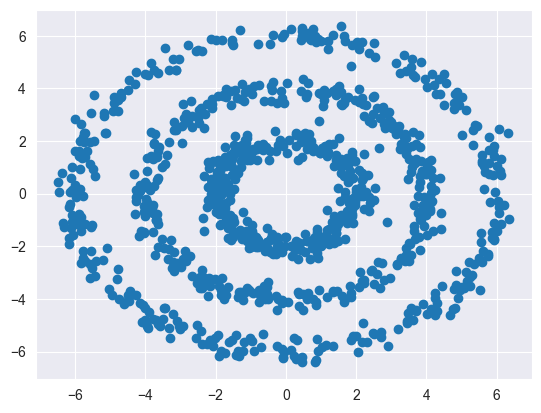

In [17]:
plt.scatter(p2_data[:, 0], p2_data[:, 1])

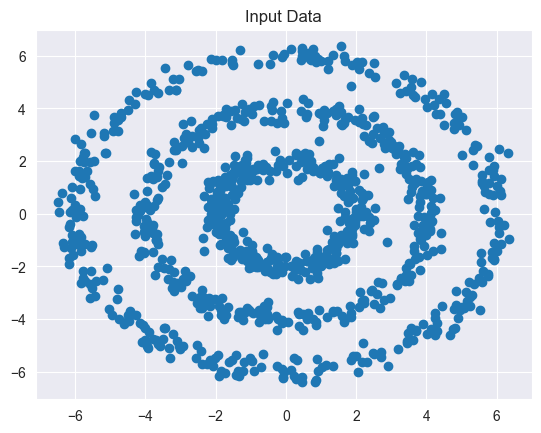

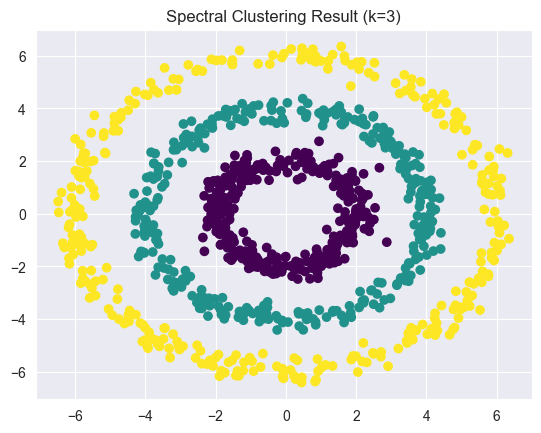

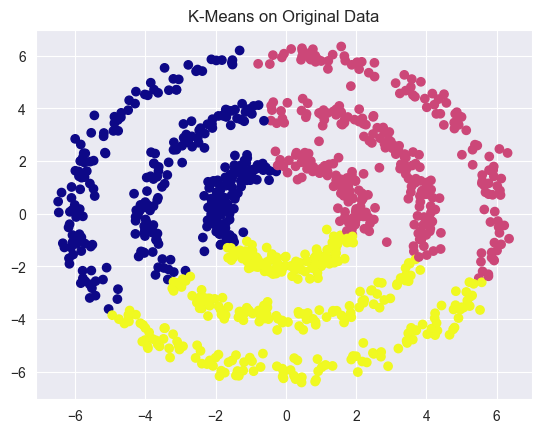

In [22]:
X = np.array(p2_data)
N = X.shape[0]

plt.scatter(X[:, 0], X[:, 1])
plt.title("Input Data")
plt.show()

def rbf_kernel(x, y, sigma=0.2):
    diff = np.linalg.norm(x - y)
    return np.exp(-diff**2 / (2 * sigma**2))


W = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        W[i, j] = rbf_kernel(X[i], X[j])

D = np.diag(W.sum(axis=1))
L = D - W
D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
L_sym = D_inv_sqrt @ L @ D_inv_sqrt

eigvals, eigvecs = np.linalg.eigh(L_sym)
idx = np.argsort(eigvals)
eigvecs = eigvecs[:, idx]
U = eigvecs[:, :3]

kmeans = KMeans(n_clusters=k, n_init=20)
labels_spec = kmeans.fit_predict(U)

plt.scatter(X[:, 0], X[:, 1], c=labels_spec, cmap='viridis')
plt.title("Spectral Clustering Result (k=3)")
plt.show()

kmeans_raw = KMeans(n_clusters=3, n_init=20)
labels_raw = kmeans_raw.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels_raw, cmap='plasma')
plt.title("K-Means on Original Data")
plt.show()